In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/data.npz
/kaggle/input/stable_kd_model/keras/default/1/student_model_final.h5
/kaggle/input/teacher/keras/default/1/sentiment_analysis_model.h5
/kaggle/input/pruned_student/keras/default/1/fully_pruned_model_latest.h5


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.models import load_model
from tqdm import tqdm

# -----------------------------------------------------------------------------
# 2. Data Loading and Preprocessing
# -----------------------------------------------------------------------------
data = np.load("/kaggle/input/dataset/data.npz")
X_train_np, y_train_np = data["X_train"], data["y_train"]
X_val_np, y_val_np = data["X_val"], data["y_val"]
X_test_np, y_test_np = data["X_test"], data["y_test"]

X_train = tf.convert_to_tensor(X_train_np, dtype=tf.int32)
y_train = tf.convert_to_tensor(y_train_np, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val_np, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val_np, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test_np, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test_np, dtype=tf.float32)

batch_size = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# -----------------------------------------------------------------------------
# 3. Load Models (Teacher and Student)
# -----------------------------------------------------------------------------
teacher_model = load_model('/kaggle/input/teacher/keras/default/1/sentiment_analysis_model.h5')
student_model = load_model('/kaggle/input/pruned_student/keras/default/1/fully_pruned_model_latest.h5')

# Explicitly define inputs
teacher_inputs = tf.keras.Input(shape=(170,), dtype=tf.int32, name="teacher_input")

# Pass input through embedding layer first
x = teacher_model.get_layer("embedding")(teacher_inputs)  # Output: (batch_size, sequence_length, embedding_dim)
teacher_bi1 = teacher_model.get_layer("bidirectional")(x)
teacher_bi2 = teacher_model.get_layer("bidirectional_1")(teacher_bi1)

# Create the corrected feature extractor model
teacher_feature_extractor = tf.keras.Model(
    inputs=teacher_inputs,
    outputs=[teacher_bi1, teacher_bi2],
    name="teacher_feature_extractor"
)

# Repeat for student model
student_inputs = tf.keras.Input(shape=(170,), dtype=tf.int32, name="student_input")
x = student_model.get_layer("embedding")(student_inputs)
student_bi1 = student_model.get_layer("bidirectional")(x)
student_bi2 = student_model.get_layer("bidirectional_1")(student_bi1)

student_feature_extractor = tf.keras.Model(
    inputs=student_inputs,
    outputs=[student_bi1, student_bi2],
    name="student_feature_extractor"
)


def get_teacher_features(images):
    return teacher_feature_extractor(images)

def get_student_features(images):
    return student_feature_extractor(images)


# inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype=tf.int32, name='input_layer')
# x = original_student.get_layer('embedding')(inputs)
# x = original_student.get_layer('bidirectional')(x)
# x = original_student.get_layer('bidirectional_1')(x)
# x = original_student.get_layer('flatten')(x)
# x = original_student.get_layer('dropout')(x)
# x = original_student.get_layer('dense')(x)
# x = original_student.get_layer('dropout_1')(x)
# x = original_student.get_layer('dense_1')(x)
# outputs = original_student.get_layer('dense_2')(x)
# student_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='student_with_same_architecture')

# # Feature mapping layers
# teacher_dense_map_bigru1 = layers.Dense(64, name='teacher_mapping_bigru1')
# teacher_dense_map_bigru2 = layers.Dense(128, name='teacher_mapping_bigru2')
# student_dense_map_bigru1 = layers.Dense(64, name='student_mapping_bigru1')
# student_dense_map_bigru2 = layers.Dense(128, name='student_mapping_bigru2')

# # -----------------------------------------------------------------------------
# # 5. Feature extraction functions (Teacher and Student)
# # -----------------------------------------------------------------------------
# def get_teacher_features(images):
#     embedding_output = teacher_model.get_layer('embedding')(images)
#     bigru1_output = teacher_model.get_layer('bidirectional')(embedding_output)
#     t_feat1 = teacher_dense_map_bigru1(bigru1_output)
#     bigru2_output = teacher_model.get_layer('bidirectional_1')(bigru1_output)
#     t_feat2 = teacher_dense_map_bigru2(bigru2_output)
#     return [t_feat1, t_feat2]

# def get_student_features(images):
#     embedding_output = student_model.get_layer('embedding')(images)
#     bigru1_output = student_model.get_layer('bidirectional')(embedding_output)
#     s_feat1 = student_dense_map_bigru1(bigru1_output)
#     bigru2_output = student_model.get_layer('bidirectional_1')(bigru1_output)
#     s_feat2 = student_dense_map_bigru2(bigru2_output)
#     return [s_feat1, s_feat2]

# -----------------------------------------------------------------------------
# 6. Improved Attention-based Feature Distillation (AFD)
# -----------------------------------------------------------------------------
bce_loss = losses.BinaryCrossentropy(from_logits=False)
mse_loss = losses.MeanSquaredError()

def attention_distillation_loss(teacher_features, student_features):
    """
    Implements AFD loss for BiGRU-based models using proper query-key attention.
    """

    # 1️⃣ Compute L2-Normalized Attention Maps Across Feature Channels
    teacher_attn = tf.nn.l2_normalize(tf.reduce_mean(teacher_features, axis=1, keepdims=True), axis=-1)
    student_attn = tf.nn.l2_normalize(tf.reduce_mean(student_features, axis=1, keepdims=True), axis=-1)

    # 2️⃣ Compute Query-Key Attention (Correct Matrix Multiplication)
    d_k = tf.cast(tf.shape(teacher_attn)[-1], tf.float32)
    scale = tf.sqrt(d_k) + 1e-8  # Prevent division by zero
    attn_scores = tf.nn.softmax(tf.matmul(teacher_attn, student_attn, transpose_b=True) / scale, axis=-1)

    # 3️⃣ Compute Feature Difference (MSE Loss)
    feature_diff = tf.reduce_mean(tf.square(teacher_attn - student_attn), axis=-1, keepdims=True)

    # 4️⃣ Multiply MSE Loss by Attention Scores (Final AFD Loss)
    attn_loss = tf.reduce_mean(attn_scores * feature_diff)

    return attn_loss




def distillation_loss(teacher_out, student_out, teacher_feats, student_feats, labels, beta):
     feat_loss1 = attention_distillation_loss(teacher_feats[0], student_feats[0])
     feat_loss2 = attention_distillation_loss(teacher_feats[1], student_feats[1])
     hard_loss = bce_loss(labels, student_out)
     return hard_loss + beta * (feat_loss1 + feat_loss2)

# -----------------------------------------------------------------------------
# 7. Training Setup
# -----------------------------------------------------------------------------
optimizer = optimizers.Adam(learning_rate=5e-5)
epochs = 20
beta = 0.5

pruned_mask = [tf.cast(tf.abs(w) > 0, dtype=tf.float32) for w in student_model.trainable_variables]
train_loss_metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy_metric = tf.keras.metrics.BinaryAccuracy('train_accuracy')
val_loss_metric = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
val_accuracy_metric = tf.keras.metrics.BinaryAccuracy('val_accuracy')

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum change in validation loss to qualify as improvement
best_val_loss = float('inf')  # Track the best validation loss
wait = 0  # Counter for epochs without improvement

# -----------------------------------------------------------------------------
# 8. Training Step (Freeze Pruned Weights)
# -----------------------------------------------------------------------------
@tf.function
def train_step(images, labels):
    labels = tf.reshape(labels, (-1, 1))
    
    with tf.GradientTape() as tape:
        teacher_out = teacher_model(images, training=False)
        student_out = student_model(images, training=True)
        t_feats = get_teacher_features(images)
        s_feats = get_student_features(images)
        total_loss = distillation_loss(teacher_out, student_out, t_feats, s_feats, labels, beta)

    grads = tape.gradient(total_loss, student_model.trainable_variables)
    masked_grads = [grad * mask for grad, mask in zip(grads, pruned_mask)]
    optimizer.apply_gradients(zip(masked_grads, student_model.trainable_variables))
    train_loss_metric.update_state(total_loss)

# -----------------------------------------------------------------------------
# 9. Validation Step
# -----------------------------------------------------------------------------
@tf.function
def val_step(images, labels):
    student_out = student_model(images, training=False)
    loss = bce_loss(labels, student_out)
    val_loss_metric.update_state(loss)
    val_accuracy_metric.update_state(labels, student_out)

def layerwise_trainable_zero_nonzero_params(model):
    for layer in model.layers:
        if hasattr(layer, 'trainable_variables'):
            for var in layer.trainable_variables:
                total = tf.size(var).numpy()
                zero = np.sum(var.numpy() == 0)
                nonzero = total - zero
                print(f"Layer: {layer.name} | Total: {total} | Zero: {zero} | Non-Zero: {nonzero}")

# -----------------------------------------------------------------------------
# 10. Training Loop with Early Stopping
# -----------------------------------------------------------------------------
num_batches_per_epoch = len(X_train_np) // batch_size
num_val_batches = len(X_val_np) // batch_size  # Calculate validation batches

# Track history for plots
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []



# Training Loop
# Training Loop with Dynamic Beta
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    train_loss_metric.reset_state()
    val_loss_metric.reset_state()
    train_accuracy_metric.reset_state()
    val_accuracy_metric.reset_state()

    # Training loop
    with tqdm(total=num_batches_per_epoch, desc="Training") as pbar:
        for step, (images, labels) in enumerate(train_dataset):
            if step >= num_batches_per_epoch:
                break
            train_step(images, labels)
            train_accuracy_metric.update_state(labels, student_model(images))
            pbar.set_postfix(loss=train_loss_metric.result().numpy())
            pbar.update(1)

    # Validation loop
    with tqdm(total=num_val_batches, desc="Validation") as pbar:
        for step, (images, labels) in enumerate(val_dataset):
            if step >= num_val_batches:
                break
            val_step(images, labels)
            pbar.set_postfix(val_loss=val_loss_metric.result().numpy(), val_accuracy=val_accuracy_metric.result().numpy())
            pbar.update(1)

    # Compute current validation loss
    current_val_loss = val_loss_metric.result().numpy()

    # Early stopping logic
    if current_val_loss < best_val_loss - min_delta:
        print(f"Validation loss improved from {best_val_loss:.4f} to {current_val_loss:.4f}")
        best_val_loss = current_val_loss
        wait = 0
    else:
        wait += 1
        print(f"Validation loss did not improve. Patience: {wait}/{patience}")

    if wait >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break
    
    # Save history
    train_loss_history.append(train_loss_metric.result().numpy())
    val_loss_history.append(val_loss_metric.result().numpy())
    train_accuracy_history.append(train_accuracy_metric.result().numpy())
    val_accuracy_history.append(val_accuracy_metric.result().numpy())

    print(f"Training Loss: {train_loss_metric.result().numpy()}, Training Accuracy: {train_accuracy_metric.result().numpy()}")
    print(f"Validation Loss: {val_loss_metric.result().numpy()}, Validation Accuracy: {val_accuracy_metric.result().numpy()}")
    layerwise_trainable_zero_nonzero_params(student_model)
# -----------------------------------------------------------------------------
# 11. Save the Final Model
# -----------------------------------------------------------------------------
# Save the final student model
student_model.save('/kaggle/working/student_model_final.h5')  # Save as HDF5 file
print("Model saved successfully!")




Epoch 1/20


Validation: 100%|██████████| 1464/1464 [00:59<00:00, 24.66it/s, val_accuracy=0.928, val_loss=0.199]


Validation loss improved from inf to 0.1993
Training Loss: 0.16312234103679657, Training Accuracy: 0.9467538595199585
Validation Loss: 0.19926409423351288, Validation Accuracy: 0.9283654093742371
Layer: embedding | Total: 1920000 | Zero: 3392 | Non-Zero: 1916608
Layer: bidirectional | Total: 12288 | Zero: 11505 | Non-Zero: 783
Layer: bidirectional | Total: 12288 | Zero: 11488 | Non-Zero: 800
Layer: bidirectional | Total: 384 | Zero: 370 | Non-Zero: 14
Layer: bidirectional | Total: 12288 | Zero: 11346 | Non-Zero: 942
Layer: bidirectional | Total: 12288 | Zero: 11489 | Non-Zero: 799
Layer: bidirectional | Total: 384 | Zero: 358 | Non-Zero: 26
Layer: bidirectional_1 | Total: 24576 | Zero: 24058 | Non-Zero: 518
Layer: bidirectional_1 | Total: 12288 | Zero: 11971 | Non-Zero: 317
Layer: bidirectional_1 | Total: 384 | Zero: 379 | Non-Zero: 5
Layer: bidirectional_1 | Total: 24576 | Zero: 23691 | Non-Zero: 885
Layer: bidirectional_1 | Total: 12288 | Zero: 11709 | Non-Zero: 579
Layer: bidirectio

Validation: 100%|██████████| 1464/1464 [00:56<00:00, 25.78it/s, val_accuracy=0.928, val_loss=0.2] 


Validation loss did not improve. Patience: 1/3
Training Loss: 0.161040797829628, Training Accuracy: 0.9477736949920654
Validation Loss: 0.20026063919067383, Validation Accuracy: 0.9282947182655334
Layer: embedding | Total: 1920000 | Zero: 3392 | Non-Zero: 1916608
Layer: bidirectional | Total: 12288 | Zero: 11505 | Non-Zero: 783
Layer: bidirectional | Total: 12288 | Zero: 11488 | Non-Zero: 800
Layer: bidirectional | Total: 384 | Zero: 370 | Non-Zero: 14
Layer: bidirectional | Total: 12288 | Zero: 11346 | Non-Zero: 942
Layer: bidirectional | Total: 12288 | Zero: 11489 | Non-Zero: 799
Layer: bidirectional | Total: 384 | Zero: 358 | Non-Zero: 26
Layer: bidirectional_1 | Total: 24576 | Zero: 24058 | Non-Zero: 518
Layer: bidirectional_1 | Total: 12288 | Zero: 11971 | Non-Zero: 317
Layer: bidirectional_1 | Total: 384 | Zero: 379 | Non-Zero: 5
Layer: bidirectional_1 | Total: 24576 | Zero: 23691 | Non-Zero: 885
Layer: bidirectional_1 | Total: 12288 | Zero: 11709 | Non-Zero: 579
Layer: bidirecti

Validation: 100%|██████████| 1464/1464 [00:56<00:00, 25.78it/s, val_accuracy=0.928, val_loss=0.202]


Validation loss did not improve. Patience: 2/3
Training Loss: 0.15935344994068146, Training Accuracy: 0.9485813975334167
Validation Loss: 0.20198389887809753, Validation Accuracy: 0.9281632900238037
Layer: embedding | Total: 1920000 | Zero: 3392 | Non-Zero: 1916608
Layer: bidirectional | Total: 12288 | Zero: 11505 | Non-Zero: 783
Layer: bidirectional | Total: 12288 | Zero: 11488 | Non-Zero: 800
Layer: bidirectional | Total: 384 | Zero: 370 | Non-Zero: 14
Layer: bidirectional | Total: 12288 | Zero: 11346 | Non-Zero: 942
Layer: bidirectional | Total: 12288 | Zero: 11489 | Non-Zero: 799
Layer: bidirectional | Total: 384 | Zero: 358 | Non-Zero: 26
Layer: bidirectional_1 | Total: 24576 | Zero: 24058 | Non-Zero: 518
Layer: bidirectional_1 | Total: 12288 | Zero: 11971 | Non-Zero: 317
Layer: bidirectional_1 | Total: 384 | Zero: 379 | Non-Zero: 5
Layer: bidirectional_1 | Total: 24576 | Zero: 23691 | Non-Zero: 885
Layer: bidirectional_1 | Total: 12288 | Zero: 11709 | Non-Zero: 579
Layer: bidirec

Validation: 100%|██████████| 1464/1464 [00:56<00:00, 25.73it/s, val_accuracy=0.928, val_loss=0.203]


Validation loss did not improve. Patience: 3/3
Early stopping triggered at epoch 4!
Model saved successfully!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Set global font properties
plt.rcParams.update({"font.family": "Times New Roman", "font.size": 12})

# -----------------------------------------------------------------------------
# 9. Plot Accuracy vs Epoch and Loss vs Epoch
# -----------------------------------------------------------------------------
epochs_range = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 5))

# Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label="Train Loss", linestyle='-', marker='o', markersize=5, alpha=0.8, linewidth=2)
plt.plot(epochs_range, val_loss_history, label="Val Loss", linestyle='--', marker='s', markersize=5, alpha=0.8, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Add grid for better visualization

# Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_history, label="Train Accuracy", linestyle='-', marker='o', markersize=5, color='blue', alpha=0.8, linewidth=2)
plt.plot(epochs_range, val_accuracy_history, label="Validation Accuracy", linestyle='--', marker='s', markersize=5, color='green', alpha=0.8, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


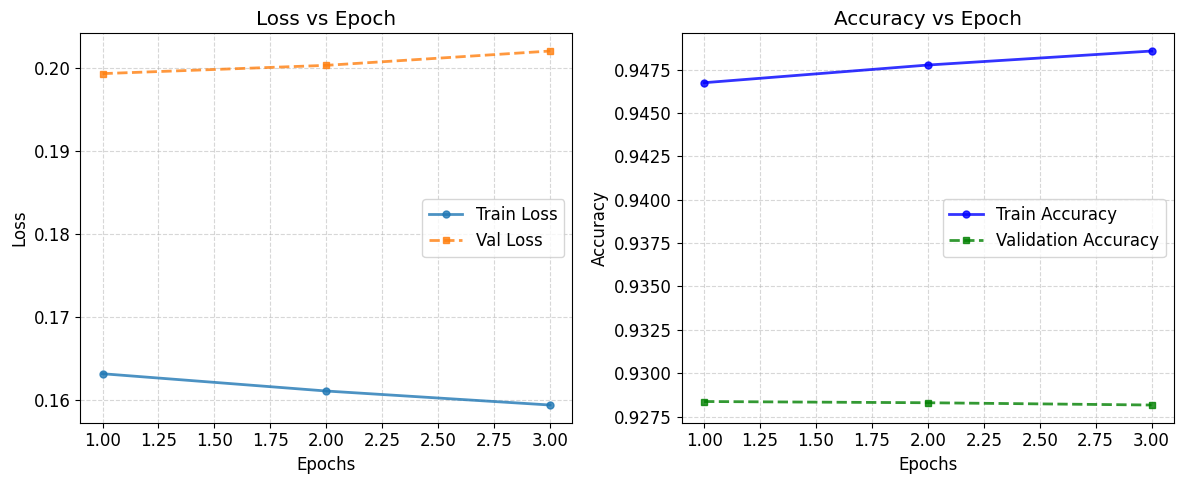

46875/46875 ━━━━━━━━━━━━━━━━━━━━ 519s 11ms/step


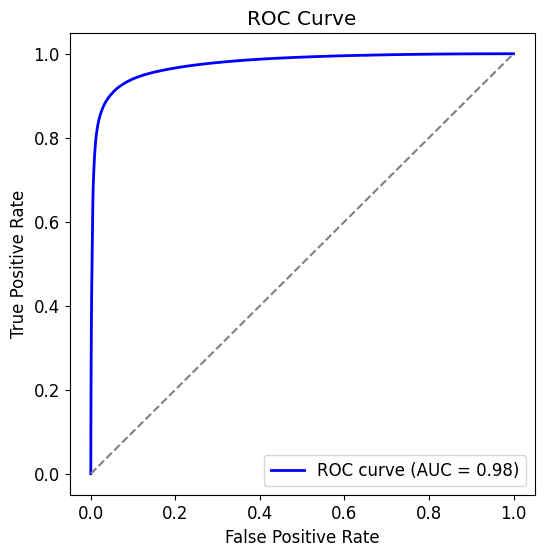

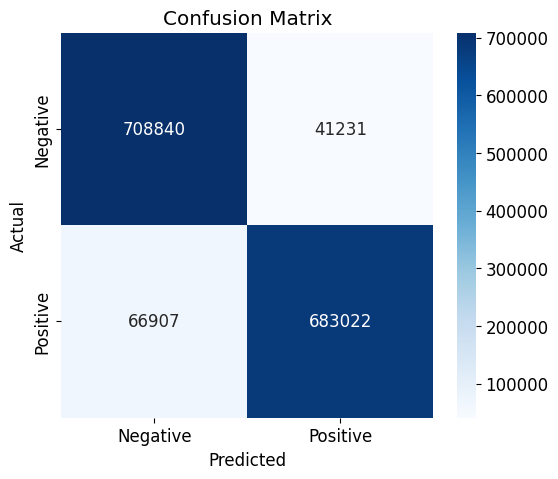

Model training complete, and evaluation metrics plotted!


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Set global font properties
plt.rcParams.update({"font.family": "Times New Roman", "font.size": 12})

# -----------------------------------------------------------------------------
# 9. Plot Accuracy vs Epoch and Loss vs Epoch
# -----------------------------------------------------------------------------
epochs_range = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 5))

# Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label="Train Loss", linestyle='-', marker='o', markersize=5, alpha=0.8, linewidth=2)
plt.plot(epochs_range, val_loss_history, label="Val Loss", linestyle='--', marker='s', markersize=5, alpha=0.8, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Add grid for better visualization

# Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_history, label="Train Accuracy", linestyle='-', marker='o', markersize=5, color='blue', alpha=0.8, linewidth=2)
plt.plot(epochs_range, val_accuracy_history, label="Validation Accuracy", linestyle='--', marker='s', markersize=5, color='green', alpha=0.8, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


# -----------------------------------------------------------------------------
# 10. ROC Curve
# -----------------------------------------------------------------------------
y_pred_probs = student_model.predict(X_test_np)
fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# -----------------------------------------------------------------------------
# 11. Confusion Matrix
# -----------------------------------------------------------------------------
J_scores = tpr - fpr  # Youden's J statistic
best_threshold = thresholds[np.argmax(J_scores)]  # Best threshold

y_pred_classes = (y_pred_probs > best_threshold).astype(int)  # Convert probabilities to class labels
conf_matrix = confusion_matrix(y_test_np, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Model training complete, and evaluation metrics plotted!")


In [13]:
import tensorflow as tf
st_ml = tf.keras.models.load_model('/kaggle/working/student_model_final.h5')


In [14]:
st_ml.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_loss, test_accuracy = st_ml.evaluate(X_test, y_test, verbose=1)

print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

46875/46875 ━━━━━━━━━━━━━━━━━━━━ 597s 13ms/step - accuracy: 0.9280 - loss: 0.2028
Testing Loss: 0.2031
Testing Accuracy: 0.9279


In [15]:
st_ml.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

val_loss, val_accuracy = st_ml.evaluate(X_val, y_val, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

46875/46875 ━━━━━━━━━━━━━━━━━━━━ 595s 13ms/step - accuracy: 0.9284 - loss: 0.2030
Validation Loss: 0.2032
Validation Accuracy: 0.9280
